In [1]:
import pandas as pd
import numpy as np
import hvplot.pandas
from sklearn.cluster import KMeans
import plotly.express as px
import psycopg2 as pg
import sqlalchemy
import matplotlib as plt
from sqlalchemy import create_engine
import pandas.io.sql as psql
import sklearn as skl
import tensorflow as tf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [5]:

#Read raw vaersdata dataframe from postgreSQL 

connection = pg.connect(host='team-11.ch3wmigorcf0.us-east-2.rds.amazonaws.com', dbname="postgres", user="postgres", password='UTB00tcamp')
#dataframe = psql.DataFrame("SELECT * FROM category", connection)
VAERS_data_df = pd.read_sql_query('select * from public."uml_source_table"',con=connection)
VAERS_data_df.head()

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,HOSPITAL,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,SYMPTOM1,...,Med_13,Med_14,Med_15,Med_16,Med_17,Med_18,Med_19,Med_20,Med_21,Med_22
0,902650,34.0,F,0,None,None,PFIZERBIONTECH,EH9899,1,Dizziness,...,None,None,None,None,None,None,None,None,None,None
1,902709,33.0,F,0,None,None,PFIZERBIONTECH,EH9899,1,Fatigue,...,None,None,None,None,None,None,None,None,None,None
2,902788,46.0,F,0,None,None,PFIZERBIONTECH,EH9899,1,Influenza like illness,...,None,None,None,None,None,None,None,None,None,None
3,902823,73.0,M,0,None,None,PFIZERBIONTECH,EU9899,UNK,Injection site erythema,...,Bu,None,None,None,None,None,None,None,None,None
4,902824,28.0,M,0,None,None,PFIZERBIONTECH,Eh9899,1,Headache,...,None,None,None,None,None,None,None,None,None,None


In [10]:
supervised_clean_data = VAERS_data_df[['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'HOSPITAL', 'VAX_MANU']].copy()
supervised_clean_data.head(20)

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,HOSPITAL,VAX_MANU
0,902650,34.0,F,0,None,None,PFIZERBIONTECH
1,902709,33.0,F,0,None,None,PFIZERBIONTECH
2,902788,46.0,F,0,None,None,PFIZERBIONTECH
3,902823,73.0,M,0,None,None,PFIZERBIONTECH
4,902824,28.0,M,0,None,None,PFIZERBIONTECH
5,902983,26.0,F,0,None,None,PFIZERBIONTECH
6,902995,37.0,F,0,None,None,PFIZERBIONTECH
7,903001,62.0,M,0,None,None,PFIZERBIONTECH
8,903010,NaN,M,0,None,None,PFIZERBIONTECH
9,903118,39.0,F,0,None,None,PFIZERBIONTECH


In [11]:
supervised_clean_data.dtypes


VAERS_ID      int64
AGE_YRS     float64
SEX          object
DIED         object
L_THREAT     object
HOSPITAL     object
VAX_MANU     object
dtype: object

In [12]:
supervised_clean_data = pd.get_dummies(supervised_clean_data, columns = ['DIED','SEX', 'L_THREAT', 'HOSPITAL', 'VAX_MANU']).copy()
supervised_clean_data.head(20)

,VAERS_ID,AGE_YRS,DIED_0,DIED_Y,SEX_F,SEX_M,SEX_U,L_THREAT_Y,HOSPITAL_Y,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER
0,902650,34.0,1,0,1,0,0,0,0,0,0,1,0
1,902709,33.0,1,0,1,0,0,0,0,0,0,1,0
2,902788,46.0,1,0,1,0,0,0,0,0,0,1,0
3,902823,73.0,1,0,0,1,0,0,0,0,0,1,0
4,902824,28.0,1,0,0,1,0,0,0,0,0,1,0
5,902983,26.0,1,0,1,0,0,0,0,0,0,1,0
6,902995,37.0,1,0,1,0,0,0,0,0,0,1,0
7,903001,62.0,1,0,0,1,0,0,0,0,0,1,0
8,903010,NaN,1,0,0,1,0,0,0,0,0,1,0
9,903118,39.0,1,0,1,0,0,0,0,0,0,1,0


In [13]:
#Create new column "SERIOUS_REACTION" that indicates whether patient had life threatening reaction, was hospitalized, or died
condition_one = (supervised_clean_data["DIED_Y"]==0) & (supervised_clean_data["HOSPITAL_Y"]==0) & (supervised_clean_data["L_THREAT_Y"]==0)
condition_two = (supervised_clean_data["DIED_Y"]==1)| (supervised_clean_data["HOSPITAL_Y"]==1) | (supervised_clean_data["L_THREAT_Y"]==1)
conditions = [condition_one, condition_two]
choices = ["0", "1"]
supervised_clean_data["SERIOUS_REACTION"] = np.select(conditions, choices)
supervised_clean_data.head(25)

,VAERS_ID,AGE_YRS,DIED_0,DIED_Y,SEX_F,SEX_M,SEX_U,L_THREAT_Y,HOSPITAL_Y,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER,SERIOUS_REACTION
0,902650,34.0,1,0,1,0,0,0,0,0,0,1,0,0
1,902709,33.0,1,0,1,0,0,0,0,0,0,1,0,0
2,902788,46.0,1,0,1,0,0,0,0,0,0,1,0,0
3,902823,73.0,1,0,0,1,0,0,0,0,0,1,0,0
4,902824,28.0,1,0,0,1,0,0,0,0,0,1,0,0
5,902983,26.0,1,0,1,0,0,0,0,0,0,1,0,0
6,902995,37.0,1,0,1,0,0,0,0,0,0,1,0,0
7,903001,62.0,1,0,0,1,0,0,0,0,0,1,0,0
8,903010,NaN,1,0,0,1,0,0,0,0,0,1,0,0
9,903118,39.0,1,0,1,0,0,0,0,0,0,1,0,0


In [14]:
supervised_clean_data.dtypes

VAERS_ID                           int64
AGE_YRS                          float64
DIED_0                             uint8
DIED_Y                             uint8
SEX_F                              uint8
SEX_M                              uint8
SEX_U                              uint8
L_THREAT_Y                         uint8
HOSPITAL_Y                         uint8
VAX_MANU_JANSSEN                   uint8
VAX_MANU_MODERNA                   uint8
VAX_MANU_PFIZERBIONTECH            uint8
VAX_MANU_UNKNOWN MANUFACTURER      uint8
SERIOUS_REACTION                  object
dtype: object

In [15]:
supervised_clean_data.AGE_YRS=supervised_clean_data.AGE_YRS.fillna(0)
supervised_clean_data.AGE_YRS = supervised_clean_data.AGE_YRS.astype(int)


In [16]:
supervised_clean_data.dtypes

VAERS_ID                          int64
AGE_YRS                           int32
DIED_0                            uint8
DIED_Y                            uint8
SEX_F                             uint8
SEX_M                             uint8
SEX_U                             uint8
L_THREAT_Y                        uint8
HOSPITAL_Y                        uint8
VAX_MANU_JANSSEN                  uint8
VAX_MANU_MODERNA                  uint8
VAX_MANU_PFIZERBIONTECH           uint8
VAX_MANU_UNKNOWN MANUFACTURER     uint8
SERIOUS_REACTION                 object
dtype: object

In [17]:
supervised_clean_data = pd.get_dummies(supervised_clean_data, columns = ['SERIOUS_REACTION']).copy()
supervised_clean_data.head(20)

,VAERS_ID,AGE_YRS,DIED_0,DIED_Y,SEX_F,SEX_M,SEX_U,L_THREAT_Y,HOSPITAL_Y,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER,SERIOUS_REACTION_0,SERIOUS_REACTION_1
0,902650,34,1,0,1,0,0,0,0,0,0,1,0,1,0
1,902709,33,1,0,1,0,0,0,0,0,0,1,0,1,0
2,902788,46,1,0,1,0,0,0,0,0,0,1,0,1,0
3,902823,73,1,0,0,1,0,0,0,0,0,1,0,1,0
4,902824,28,1,0,0,1,0,0,0,0,0,1,0,1,0
5,902983,26,1,0,1,0,0,0,0,0,0,1,0,1,0
6,902995,37,1,0,1,0,0,0,0,0,0,1,0,1,0
7,903001,62,1,0,0,1,0,0,0,0,0,1,0,1,0
8,903010,0,1,0,0,1,0,0,0,0,0,1,0,1,0
9,903118,39,1,0,1,0,0,0,0,0,0,1,0,1,0


In [18]:
#set VAERS_ID as index
supervised_clean_data.set_index("VAERS_ID", inplace=True)
supervised_clean_data.head()

,AGE_YRS,DIED_0,DIED_Y,SEX_F,SEX_M,SEX_U,L_THREAT_Y,HOSPITAL_Y,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER,SERIOUS_REACTION_0,SERIOUS_REACTION_1
VAERS_ID,,,,,,,,,,,,,,
902650,34,1,0,1,0,0,0,0,0,0,1,0,1,0
902709,33,1,0,1,0,0,0,0,0,0,1,0,1,0
902788,46,1,0,1,0,0,0,0,0,0,1,0,1,0
902823,73,1,0,0,1,0,0,0,0,0,1,0,1,0
902824,28,1,0,0,1,0,0,0,0,0,1,0,1,0


In [19]:
len(supervised_clean_data.index)


50716

In [20]:
### Logistic Regression Model to predict Serious Reaction
y = supervised_clean_data["SERIOUS_REACTION_1"]
X = supervised_clean_data.drop(["DIED_0", "DIED_Y", "L_THREAT_Y", "HOSPITAL_Y", "SERIOUS_REACTION_0", "SERIOUS_REACTION_1"], axis=1)
X.head()

,AGE_YRS,SEX_F,SEX_M,SEX_U,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER
VAERS_ID,,,,,,,,
902650,34,1,0,0,0,0,1,0
902709,33,1,0,0,0,0,1,0
902788,46,1,0,0,0,0,1,0
902823,73,0,1,0,0,0,1,0
902824,28,0,1,0,0,0,1,0


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y, test_size = 0.30, random_state=1, stratify=y)

In [22]:
# Create a StandardScaler instance
from sklearn.preprocessing import StandardScaler,OneHotEncoder


scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
   max_iter=200,
   random_state=1)

In [24]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [25]:
y_pred = classifier.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8731514952349655


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[12921   183]
 [ 1747   364]]


In [28]:
#Create dataframe from confusion matrix
matrix_df = pd.DataFrame(
matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
matrix_df

,Predicted 0,Predicted 1
Actual 0,12921,183
Actual 1,1747,364


In [29]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     13104
           1       0.67      0.17      0.27      2111

    accuracy                           0.87     15215
   macro avg       0.77      0.58      0.60     15215
weighted avg       0.85      0.87      0.84     15215



<AxesSubplot:xlabel='SERIOUS_REACTION_1', ylabel='count'>

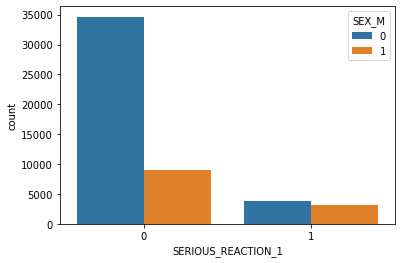

In [47]:
import seaborn as sns
sns.countplot(x='SERIOUS_REACTION_1', hue='SEX_M', data= supervised_clean_data)

<AxesSubplot:xlabel='SERIOUS_REACTION_1', ylabel='count'>

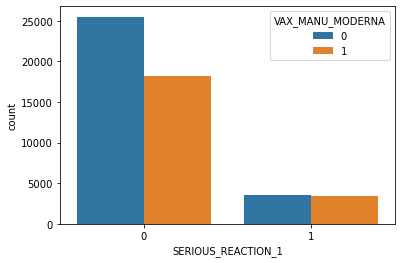

In [49]:
sns.countplot(x='SERIOUS_REACTION_1', hue= 'VAX_MANU_MODERNA', data= supervised_clean_data)




<AxesSubplot:xlabel='SERIOUS_REACTION_1', ylabel='count'>

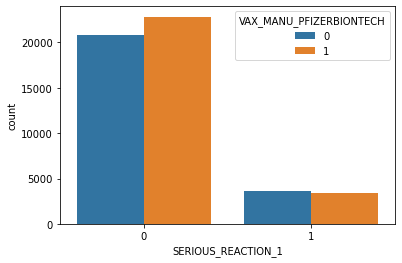

In [50]:
sns.countplot(x='SERIOUS_REACTION_1', hue= 'VAX_MANU_PFIZERBIONTECH', data= supervised_clean_data)

In [57]:
vax_types = supervised_clean_data[['VAX_MANU_MODERNA', 'VAX_MANU_PFIZERBIONTECH', 'VAX_MANU_JANSSEN']]


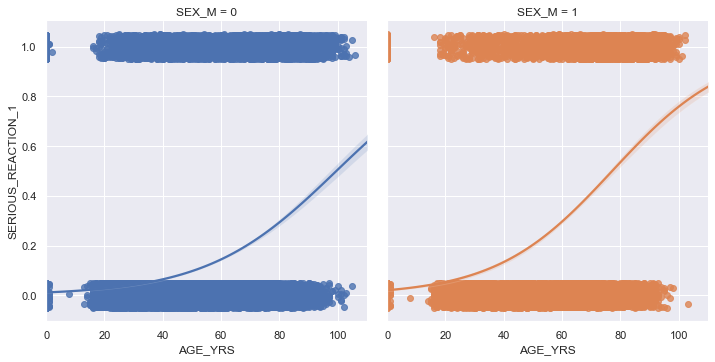

In [65]:
sns.set_theme(style="darkgrid")



# Make a custom palette with gendered colors


# Show the survival probability as a function of age and sex
g = sns.lmplot(x="AGE_YRS", y="SERIOUS_REACTION_1", col="SEX_M", hue="SEX_M", data=supervised_clean_data,
                logistic=True, y_jitter = .05, truncate=False)
g.set(xlim=(0,110))


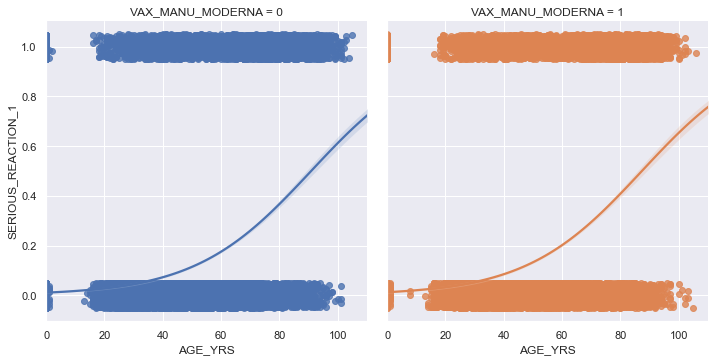

In [71]:
sns.set_theme(style="darkgrid")



# Make a custom palette with gendered colors


# Show the survival probability as a function of age and sex
g = sns.lmplot(x="AGE_YRS", y="SERIOUS_REACTION_1", col="VAX_MANU_MODERNA", hue="VAX_MANU_MODERNA", data=supervised_clean_data,
                logistic=True, y_jitter = .05, truncate=False)
g.set(xlim=(0,110))

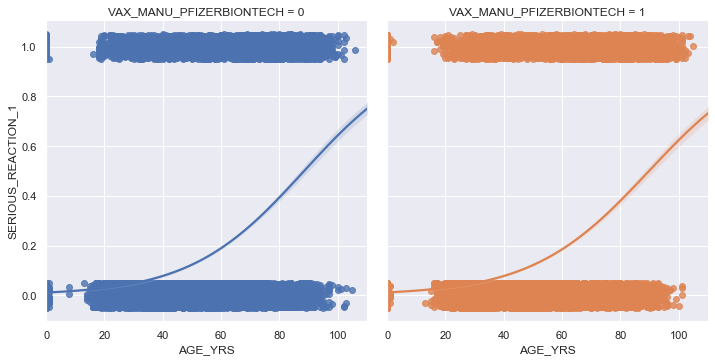

In [68]:
sns.set_theme(style="darkgrid")



# Make a custom palette with gendered colors


# Show the survival probability as a function of age and sex
g = sns.lmplot(x="AGE_YRS", y="SERIOUS_REACTION_1", col="VAX_MANU_PFIZERBIONTECH", hue="VAX_MANU_PFIZERBIONTECH", data=supervised_clean_data,
                logistic=True, y_jitter = .05, truncate=False)
g.set(xlim=(0,110))

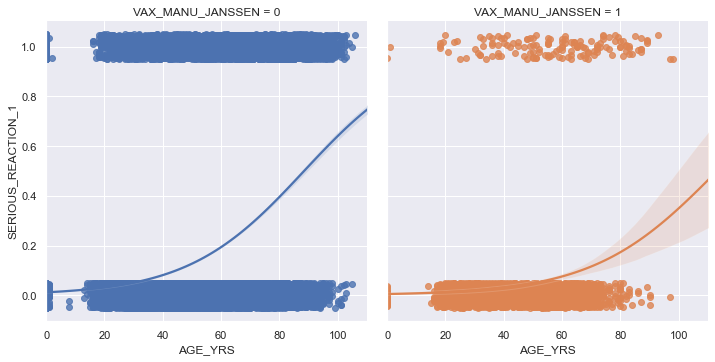

In [69]:
sns.set_theme(style="darkgrid")



# Make a custom palette with gendered colors


# Show the survival probability as a function of age and sex
g = sns.lmplot(x="AGE_YRS", y="SERIOUS_REACTION_1", col="VAX_MANU_JANSSEN", hue="VAX_MANU_JANSSEN", data=supervised_clean_data,
                logistic=True, y_jitter = .05, truncate=False)
g.set(xlim=(0,110))

In [289]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ VAX_MANU_MODERNA ", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27206.
Date:                Thu, 08 Apr 2021   Deviance:                       54413.
Time:                        18:59:02   Pearson chi2:                 5.81e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.6337      0.015   -111.145      0.000      -1.662      -1.605
VAX_MANU_MODERNA     0.2487      0.022     11.427      0.000       0.206       0.291
====================================================================================
"""

In [290]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ VAX_MANU_JANSSEN ", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27048.
Date:                Thu, 08 Apr 2021   Deviance:                       54096.
Time:                        18:59:02   Pearson chi2:                 5.81e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4799      0.011   -135.143      0.000      -1.501      -1.458
VAX_MANU_JANSSEN    -1.4609      0.086    -17.004      0.000      -1.629      -1.292
====================================================================================
"""

In [291]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ VAX_MANU_PFIZERBIONTECH ", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27265.
Date:                Thu, 08 Apr 2021   Deviance:                       54530.
Time:                        18:59:02   Pearson chi2:                 5.81e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.4843      0.016    -94.932      0.000      -1.515      -1.454
VAX_MANU_PFIZERBIONTECH    -0.0776      0.022     -3.581      0.000      -0.120      -0.035
===========================================================================================
"""

In [292]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ SEX_F", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26223.
Date:                Thu, 08 Apr 2021   Deviance:                       52445.
Time:                        18:59:02   Pearson chi2:                 5.81e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8395      0.017    -48.673      0.000      -0.873      -0.806
SEX_F         -1.0427      0.022    -46.426      0.000      -1.087      -0.999
==============================================================================
"""

In [293]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ SEX_M ", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26085.
Date:                Thu, 08 Apr 2021   Deviance:                       52171.
Time:                        18:59:02   Pearson chi2:                 5.81e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8867      0.014   -132.948      0.000      -1.915      -1.859
SEX_M          1.1252      0.023     49.538      0.000       1.081       1.170
==============================================================================
"""

In [294]:
model = sm.GLM.from_formula("SERIOUS_REACTION_1 ~ AGE_YRS ", family = sm.families.Binomial(), data=supervised_clean_data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     SERIOUS_REACTION_1   No. Observations:                58095
Model:                            GLM   Df Residuals:                    58093
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23260.
Date:                Thu, 08 Apr 2021   Deviance:                       46520.
Time:                        18:59:03   Pearson chi2:                 8.47e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3024      0.040   -107.572      0.000      -4.381      -4.224
AGE_YRS        0.0519      0.001     79.677      0.000       0.051       0.053
==============================================================================
"""

In [295]:
supervised_clean_data.cov()

,AGE_YRS,DIED_0,DIED_Y,SEX_F,SEX_M,SEX_U,L_THREAT_Y,HOSPITAL_Y,VAX_MANU_JANSSEN,VAX_MANU_MODERNA,VAX_MANU_PFIZERBIONTECH,VAX_MANU_UNKNOWN MANUFACTURER,SERIOUS_REACTION_0,SERIOUS_REACTION_1
AGE_YRS,461.233997,-1.495821,1.495821,-0.718655,1.413381,-6.947261e-01,0.377106,1.716971,-0.029264,0.851731,-0.822711,2.441034e-04,-2.908532,2.908532
DIED_0,-1.495821,0.052279,-0.052279,0.016746,-0.016975,2.294538e-04,0.000451,-0.004390,0.002254,-0.002349,0.000261,-1.665525e-04,0.045451,-0.045451
DIED_Y,1.495821,-0.052279,0.052279,-0.016746,0.016975,-2.294538e-04,-0.000451,0.004390,-0.002254,0.002349,-0.000261,1.665525e-04,-0.045451,0.045451
SEX_F,-0.718655,0.016746,-0.016746,0.199246,-0.182928,-1.631770e-02,-0.004763,-0.020116,-0.001706,0.001419,0.000432,-1.456670e-04,0.033773,-0.033773
SEX_M,1.413381,-0.016975,0.016975,-0.182928,0.188602,-5.674172e-03,0.005481,0.021145,0.002464,0.001489,-0.004098,1.447186e-04,-0.035212,0.035212
SEX_U,-0.694726,0.000229,-0.000229,-0.016318,-0.005674,2.199187e-02,-0.000718,-0.001029,-0.000758,-0.002909,0.003666,9.484526e-07,0.001439,-0.001439
L_THREAT_Y,0.377106,0.000451,-0.000451,-0.004763,0.005481,-7.177946e-04,0.037992,0.022955,-0.001400,0.002355,-0.000961,5.829384e-06,-0.032488,0.032488
HOSPITAL_Y,1.716971,-0.004390,0.004390,-0.020116,0.021145,-1.029030e-03,0.022955,0.108460,-0.004161,0.005346,-0.001319,1.342865e-04,-0.101661,0.101661
VAX_MANU_JANSSEN,-0.029264,0.002254,-0.002254,-0.001706,0.002464,-7.577058e-04,-0.001400,-0.004161,0.047272,-0.020743,-0.026493,-3.596475e-05,0.006394,-0.006394
VAX_MANU_MODERNA,0.851731,-0.002349,0.002349,0.001419,0.001489,-2.908780e-03,0.002355,0.005346,-0.020743,0.243111,-0.222066,-3.014568e-04,-0.008968,0.008968


In [72]:
### Logistic Regression With Symptoms, Medications and Allergies added as features


connection = pg.connect(host='team-11.ch3wmigorcf0.us-east-2.rds.amazonaws.com', dbname="postgres", user="postgres", password='UTB00tcamp')
#dataframe = psql.DataFrame("SELECT * FROM category", connection)
full_ml_df = pd.read_sql_query('select * from public."ml_models_table"',con=connection)
full_ml_df.head()

,VAERS_ID,AGE_YRS,SEX,VAX_MANU,Allergy_1,SYMPTOM1,Med_1,ADV_REACTION,MULTIVITAMIN,VITAMIN B,...,ROSUVASTATIN,PRAVASTATIN,PEPSID,XARELTO,BALLOFEN,CASIRIVIMAB,LEVOXYL,ESTRADIOL,LITHIUM,XANAX
0,902650,34.0,F,PFIZERBIONTECH,NONE,DIZZINESS,NONE,N,N,N,...,N,N,N,N,N,N,N,N,N,N
1,902709,33.0,F,PFIZERBIONTECH,NONE,FATIGUE,FLUVOXAMINE,N,N,N,...,N,N,N,N,N,N,N,N,N,N
2,902788,46.0,F,PFIZERBIONTECH,NONE,INFLUENZA LIKE ILLNESS,NONE,N,N,N,...,N,N,N,N,N,N,N,N,N,N
3,902823,73.0,M,PFIZERBIONTECH,SULFA,INJECTION SITE ERYTHEMA,OXYBUTYNIN 5MG DAILY,N,N,N,...,N,N,N,N,N,N,N,N,N,N
4,902824,28.0,M,PFIZERBIONTECH,CEPHALOSPORINS,HEADACHE,NONE,N,N,N,...,N,N,N,N,N,N,N,N,N,N
